In [1]:
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
import os, glob
import numpy as np
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from numpy import mean, std
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import optimizers, metrics, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline
from plot_history import plot_history
import tensorflow_addons as tfa
from sklearn.pipeline import Pipeline
from functions import show_training_plot, show_confusion_matrix, show_roc_plot

**PRE-PROCESSING FUNCTIONS**

In [2]:
def load_openface():
    path = "/Volumes/ARYA/Data/OpenFace Data/All/"

    all_files = sorted(glob.glob(os.path.join(path, "*.csv")))

    cols = [
        'frame',
        'AU01_r',
        'AU02_r',
        'AU04_r',
        'AU05_r',
        'AU06_r',
        'AU07_r',
        'AU09_r',
        'AU10_r',
        'AU12_r',
        'AU14_r',
        'AU15_r',
        'AU17_r',
        'AU20_r',
        'AU23_r',
        'AU25_r',
        'AU26_r',
        'AU45_r',
        'id'
    ]

    pitch_merged =  pd.DataFrame()
    for i, f in enumerate(all_files):
        temp = pd.read_csv(f)
        temp['id'] = i
        temp.columns = temp.columns.str.strip()
        pitch_merged = pd.concat([pitch_merged, temp[cols][250:3750]], ignore_index=True)
    
    return pitch_merged

In [3]:
def load_facereader():
    path = "/Volumes/ARYA/Data/FaceReader Data/All/"

    all_files = sorted(glob.glob(os.path.join(path, "*.txt")))

    cols = [
        'frame',
        'Action Unit 01 - Inner Brow Raiser',
        'Action Unit 02 - Outer Brow Raiser',
        'Action Unit 04 - Brow Lowerer',
        'Action Unit 05 - Upper Lid Raiser',
        'Action Unit 06 - Cheek Raiser',
        'Action Unit 07 - Lid Tightener',
        'Action Unit 09 - Nose Wrinkler',
        'Action Unit 10 - Upper Lip Raiser',
        'Action Unit 12 - Lip Corner Puller',
        'Action Unit 14 - Dimpler',
        'Action Unit 15 - Lip Corner Depressor',
        'Action Unit 17 - Chin Raiser',
        'Action Unit 20 - Lip Stretcher',
        'Action Unit 23 - Lip Tightener',
        'Action Unit 25 - Lips Part',
        'Action Unit 26 - Jaw Drop',
        'id'
    ]

    pitch_merged =  pd.DataFrame()
    for i, f in enumerate(all_files):
        temp = pd.read_csv(f, sep='\t', skiprows=8)
        temp['frame'] = range(1, 1+len(temp))
        temp['id'] = i
        #temp.columns = temp.columns.str.strip()
        pitch_merged = pd.concat([pitch_merged, temp[cols][250:3750]], ignore_index=True)
        
    return pitch_merged

In [33]:
def preprocess_lstm_openface(openface_data, au_set, sampling):
    
    if (au_set == 'all'):
        features = [
            'AU01_r',
            'AU02_r',
            'AU04_r',
            'AU05_r',
            'AU06_r',
            'AU07_r',
            'AU09_r',
            'AU10_r',
            'AU12_r',
            'AU14_r',
            'AU15_r',
            'AU17_r',
            'AU20_r',
            'AU23_r',
            'AU25_r',
            'AU26_r'
        ]
        
        pitch_merged_features = openface_data[features]
    
    elif (au_set == 'concentration'):
        features = [
            'AU05_r',
            'AU07_r',
            'AU12_r',
            'AU25_r',
            'AU26_r'
        ]
        
        pitch_merged_features = openface_data[features]
        pitch_merged_features['AU07+12_r'] = pitch_merged_features['AU07_r'] + pitch_merged_features['AU12_r']
        del pitch_merged_features['AU07_r']
        del pitch_merged_features['AU12_r']
    
    else: # interest
        features = [
            'AU06_r',
            'AU07_r',
            'AU12_r'
        ]
        
        pitch_merged_features = openface_data[features]
        pitch_merged_features['AU06+12_r'] = pitch_merged_features['AU06_r'] + pitch_merged_features['AU12_r']
        del pitch_merged_features['AU06_r']
        del pitch_merged_features['AU12_r']  
    
    if (sampling == 'frame'):
        # Use every ith frames
        pitch_merged_features = pitch_merged_features.iloc[::50, :]
    
    else: # mean
        pitch_merged_features['frame'] = list(range(251, 3751))*87
        sampling = np.array(range(6090))
        sampling = np.repeat(sampling, 50)
        pitch_merged_features['sampling'] = sampling
        
        settings = {
            "mean": None
        }

        pitch_merged_features = extract_features(pitch_merged_features, column_id="sampling", column_sort="frame", default_fc_parameters=settings)
        
    # Normalization
    features_min = np.array(pitch_merged_features).min()
    features_max = np.array(pitch_merged_features).max()
    pitch_merged_features = ((pitch_merged_features - features_min) / (features_max - features_min))**2
    
    X = pitch_merged_features.to_numpy()
    X = X.reshape((87, 70, len(pitch_merged_features.columns)))
    
    return X    

In [34]:
def preprocess_lstm_facereader(facereader_data, au_set, sampling):
    
    # cleaning
    facereader_data_clean = facereader_data.replace('FIND_FAILED', '0.000000000')
    facereader_data_clean = facereader_data_clean.replace('FIT_FAILED', '0.000000000')
    
    # convert from string
    facereader_data_clean = facereader_data_clean.astype('float')
    
    if (au_set == 'all'):
        features = [
            'Action Unit 01 - Inner Brow Raiser',
            'Action Unit 02 - Outer Brow Raiser',
            'Action Unit 04 - Brow Lowerer',
            'Action Unit 05 - Upper Lid Raiser',
            'Action Unit 06 - Cheek Raiser',
            'Action Unit 07 - Lid Tightener',
            'Action Unit 09 - Nose Wrinkler',
            'Action Unit 10 - Upper Lip Raiser',
            'Action Unit 12 - Lip Corner Puller',
            'Action Unit 14 - Dimpler',
            'Action Unit 15 - Lip Corner Depressor',
            'Action Unit 17 - Chin Raiser',
            'Action Unit 20 - Lip Stretcher',
            'Action Unit 23 - Lip Tightener',
            'Action Unit 25 - Lips Part',
            'Action Unit 26 - Jaw Drop'
        ]
        
        pitch_merged_features = facereader_data_clean[features]
    
    elif (au_set == 'concentration'):
        features = [
            'Action Unit 05 - Upper Lid Raiser',
            'Action Unit 07 - Lid Tightener',
            'Action Unit 12 - Lip Corner Puller',
            'Action Unit 25 - Lips Part',
            'Action Unit 26 - Jaw Drop'
        ]
        
        pitch_merged_features = facereader_data_clean[features]
        pitch_merged_features['AU07+12'] = pitch_merged_features['Action Unit 07 - Lid Tightener'] + pitch_merged_features['Action Unit 12 - Lip Corner Puller']
        del pitch_merged_features['Action Unit 07 - Lid Tightener']
        del pitch_merged_features['Action Unit 12 - Lip Corner Puller']
    
    else: # interest
        features = [
            'Action Unit 06 - Cheek Raiser',
            'Action Unit 07 - Lid Tightener',
            'Action Unit 12 - Lip Corner Puller'
        ]
        
        pitch_merged_features = facereader_data_clean[features]
        pitch_merged_features['AU06+12'] = pitch_merged_features['Action Unit 06 - Cheek Raiser'] + pitch_merged_features['Action Unit 12 - Lip Corner Puller']
        del pitch_merged_features['Action Unit 06 - Cheek Raiser']
        del pitch_merged_features['Action Unit 12 - Lip Corner Puller']
    
    if (sampling == 'frame'):
        # Use every ith frames
        pitch_merged_features = pitch_merged_features.iloc[::50, :]
    
    else: # mean
        pitch_merged_features['frame'] = list(range(251, 3751))*87
        sampling = np.array(range(6090))
        sampling = np.repeat(sampling, 50)
        pitch_merged_features['sampling'] = sampling
        
        settings = {
            "mean": None
        }

        pitch_merged_features = extract_features(pitch_merged_features, column_id="sampling", column_sort="frame", default_fc_parameters=settings)
        
    # Normalization
    features_min = np.array(pitch_merged_features).min()
    features_max = np.array(pitch_merged_features).max()
    pitch_merged_features = ((pitch_merged_features - features_min) / (features_max - features_min))**2
    
    X = pitch_merged_features.to_numpy()
    X = X.reshape((87, 70, len(pitch_merged_features.columns)))
    
    return X

In [27]:
def preprocess_svm_openface(openface_data, au_set):
    
    if (au_set == 'all'):
        features = [
            'frame',
            'AU01_r',
            'AU02_r',
            'AU04_r',
            'AU05_r',
            'AU06_r',
            'AU07_r',
            'AU09_r',
            'AU10_r',
            'AU12_r',
            'AU14_r',
            'AU15_r',
            'AU17_r',
            'AU20_r',
            'AU23_r',
            'AU25_r',
            'AU26_r',
            'id'
        ]
        
        pitch_merged_features = openface_data[features]
    
    elif (au_set == 'concentration'):
        features = [
            'frame',
            'AU05_r',
            'AU07_r',
            'AU12_r',
            'AU25_r',
            'AU26_r',
            'id'
        ]
        
        pitch_merged_features = openface_data[features]
        pitch_merged_features['AU07+12_r'] = pitch_merged_features['AU07_r'] + pitch_merged_features['AU12_r']
        del pitch_merged_features['AU07_r']
        del pitch_merged_features['AU12_r']
    
    else: # interest
        features = [
            'frame',
            'AU06_r',
            'AU07_r',
            'AU12_r',
            'id'
        ]
        
        pitch_merged_features = openface_data[features]
        pitch_merged_features['AU06+12_r'] = pitch_merged_features['AU06_r'] + pitch_merged_features['AU12_r']
        del pitch_merged_features['AU06_r']
        del pitch_merged_features['AU12_r']
        
    # To numpy for normalization
    if (au_set == 'all'):
        aus = [
            'AU01_r',
            'AU02_r',
            'AU04_r',
            'AU05_r',
            'AU06_r',
            'AU07_r',
            'AU09_r',
            'AU10_r',
            'AU12_r',
            'AU14_r',
            'AU15_r',
            'AU17_r',
            'AU20_r',
            'AU23_r',
            'AU25_r',
            'AU26_r'
        ]
    elif (au_set ==  'concentration'):
        aus = [
            'AU05_r',
            'AU07+12_r',
            'AU25_r',
            'AU26_r'
        ]
    else: # interest
        aus = [
            'AU06+12_r',
            'AU07_r'
        ]

    pre_normalized_aus = pitch_merged_features[aus].to_numpy()
        
    # Squared Min-Max Normalization
    aus_min = pre_normalized_aus.min()
    aus_max = pre_normalized_aus.max()
    normalized_aus = ((pre_normalized_aus - aus_min) / (aus_max - aus_min))**2
    
    # Back to DF including frame and id for temporal features extraction
    normalized_features = pd.DataFrame(data=normalized_aus, columns=aus)
    
    normalized_features['frame'] = pitch_merged_features['frame']
    normalized_features['id'] = pitch_merged_features['id']
    
    settings = {
        "mean": None,
        "standard_deviation": None,
    }

    pitch_extracted_features = extract_features(normalized_features, column_id="id", column_sort="frame", default_fc_parameters=settings)
    
    X = pitch_extracted_features.to_numpy()
    
    return X

In [24]:
def preprocess_svm_facereader(facereader_data, au_set):
    
    # cleaning
    facereader_data_clean = facereader_data.replace('FIND_FAILED', '0.000000000')
    facereader_data_clean = facereader_data_clean.replace('FIT_FAILED', '0.000000000')
    
    # convert from string
    facereader_data_clean = facereader_data_clean.astype('float')
    
    if (au_set == 'all'):
        features = [
            'frame',
            'Action Unit 01 - Inner Brow Raiser',
            'Action Unit 02 - Outer Brow Raiser',
            'Action Unit 04 - Brow Lowerer',
            'Action Unit 05 - Upper Lid Raiser',
            'Action Unit 06 - Cheek Raiser',
            'Action Unit 07 - Lid Tightener',
            'Action Unit 09 - Nose Wrinkler',
            'Action Unit 10 - Upper Lip Raiser',
            'Action Unit 12 - Lip Corner Puller',
            'Action Unit 14 - Dimpler',
            'Action Unit 15 - Lip Corner Depressor',
            'Action Unit 17 - Chin Raiser',
            'Action Unit 20 - Lip Stretcher',
            'Action Unit 23 - Lip Tightener',
            'Action Unit 25 - Lips Part',
            'Action Unit 26 - Jaw Drop',
            'id'
        ]
        
        pitch_merged_features = facereader_data_clean[features]
    
    elif (au_set == 'concentration'):
        features = [
            'frame',
            'Action Unit 05 - Upper Lid Raiser',
            'Action Unit 07 - Lid Tightener',
            'Action Unit 12 - Lip Corner Puller',
            'Action Unit 25 - Lips Part',
            'Action Unit 26 - Jaw Drop',
            'id'
        ]
        
        pitch_merged_features = facereader_data_clean[features]
        pitch_merged_features['AU07+12'] = pitch_merged_features['Action Unit 07 - Lid Tightener'] + pitch_merged_features['Action Unit 12 - Lip Corner Puller']
        del pitch_merged_features['Action Unit 07 - Lid Tightener']
        del pitch_merged_features['Action Unit 12 - Lip Corner Puller']
    
    else: # interest
        features = [
            'frame',
            'Action Unit 06 - Cheek Raiser',
            'Action Unit 07 - Lid Tightener',
            'Action Unit 12 - Lip Corner Puller',
            'id'
        ]
        
        pitch_merged_features = facereader_data_clean[features]
        pitch_merged_features['AU06+12'] = pitch_merged_features['Action Unit 06 - Cheek Raiser'] + pitch_merged_features['Action Unit 12 - Lip Corner Puller']
        del pitch_merged_features['Action Unit 06 - Cheek Raiser']
        del pitch_merged_features['Action Unit 12 - Lip Corner Puller']
        
    # To numpy for normalization
    if (au_set == 'all'):
        aus = [
            'Action Unit 01 - Inner Brow Raiser',
            'Action Unit 02 - Outer Brow Raiser',
            'Action Unit 04 - Brow Lowerer',
            'Action Unit 05 - Upper Lid Raiser',
            'Action Unit 06 - Cheek Raiser',
            'Action Unit 07 - Lid Tightener',
            'Action Unit 09 - Nose Wrinkler',
            'Action Unit 10 - Upper Lip Raiser',
            'Action Unit 12 - Lip Corner Puller',
            'Action Unit 14 - Dimpler',
            'Action Unit 15 - Lip Corner Depressor',
            'Action Unit 17 - Chin Raiser',
            'Action Unit 20 - Lip Stretcher',
            'Action Unit 23 - Lip Tightener',
            'Action Unit 25 - Lips Part',
            'Action Unit 26 - Jaw Drop'
        ]
    elif (au_set ==  'concentration'):
        aus = [
            'Action Unit 05 - Upper Lid Raiser',
            'AU07+12',
            'Action Unit 25 - Lips Part',
            'Action Unit 26 - Jaw Drop'
        ]
    else: # interest
        aus = [
            'AU06+12',
            'Action Unit 07 - Lid Tightener'
        ]

    pre_normalized_aus = pitch_merged_features[aus].to_numpy()
        
    # Squared Min-Max Normalization
    aus_min = pre_normalized_aus.min()
    aus_max = pre_normalized_aus.max()
    normalized_aus = ((pre_normalized_aus - aus_min) / (aus_max - aus_min))**2
    
    # Back to DF including frame and id for temporal features extraction
    normalized_features = pd.DataFrame(data=normalized_aus, columns=aus)
    
    normalized_features['frame'] = pitch_merged_features['frame']
    normalized_features['id'] = pitch_merged_features['id']
    
    settings = {
        "mean": None,
        "standard_deviation": None,   
    }

    pitch_extracted_features = extract_features(normalized_features, column_id="id", column_sort="frame", default_fc_parameters=settings)
    
    X = pitch_extracted_features.to_numpy()
    
    return X

In [8]:
def load_labels():
    pitch_labels = pd.read_csv('/Volumes/ARYA/Data/Survey Data/pitch_labels.csv')
    y = pitch_labels['probinv.class'].to_numpy()
    
    return y

**LOAD DATA**

In [9]:
openface_data = load_openface()

In [10]:
facereader_data = load_facereader()

/var/folders/nd/246mzcq534z91cvm7nkz_81c0000gn/T/ipykernel_1105/1825469525.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  facereader_data = load_facereader()


**LOAD LABELS**

In [11]:
y = load_labels()

**LOAD FEATURES**

In [12]:
au_sets = ['all', 'concentration', 'interest']

In [38]:
svm_features = {}

for au_set in au_sets:
    svm_features['openface_' + au_set] = preprocess_svm_openface(openface_data, au_set)
    svm_features['facereader_' + au_set] = preprocess_svm_facereader(facereader_data, au_set)

Feature Extraction: 100%|███████████████████████| 10/10 [00:03<00:00,  3.08it/s]
/var/folders/nd/246mzcq534z91cvm7nkz_81c0000gn/T/ipykernel_1105/72425130.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitch_merged_features['AU07+12_r'] = pitch_merged_features['AU07_r'] + pitch_merged_features['AU12_r']
Feature Extraction: 100%|███████████████████████| 10/10 [00:02<00:00,  3.52it/s]
/var/folders/nd/246mzcq534z91cvm7nkz_81c0000gn/T/ipykernel_1105/4030474786.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [41]:
samplings = ['frame', 'mean']

lstm_features = {}

for au_set in au_sets:
    for sampling in samplings:
        lstm_features['openface_' + au_set + '_' + sampling] = preprocess_lstm_openface(openface_data, au_set, sampling)
        lstm_features['facereader_' + au_set + '_' + sampling] = preprocess_lstm_facereader(facereader_data, au_set, sampling)

/var/folders/nd/246mzcq534z91cvm7nkz_81c0000gn/T/ipykernel_1105/3859590378.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitch_merged_features['frame'] = list(range(251, 3751))*87
/var/folders/nd/246mzcq534z91cvm7nkz_81c0000gn/T/ipykernel_1105/3859590378.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitch_merged_features['sampling'] = sampling
Feature Extraction: 100%|███████████████████████| 10/10 [00:12<00:00,  1.29s/it]
/var/folders/nd/246mzcq534z91cvm7nkz_81c0000gn/T/ipykernel_1105/3336675

Feature Extraction: 100%|███████████████████████| 10/10 [00:05<00:00,  1.76it/s]


**BUILD MODELS**

In [36]:
kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=8080)

**SVM**

Variation:  openface_all
Fold: # 1
Coefficients: [[ 14.20330205  -5.56362917 -39.17319032  15.95243466 -15.9054517
   18.62542334  -4.98217118 -14.00437402 -56.04443007 -30.89413331
    3.58845788 -31.75723423  -2.34691438 -16.3480882   -9.07587799
   10.18894898  41.6491059   14.04867167  16.56670538  -7.33460254
  -17.19822457  11.29188601  -1.72119389  -4.33182305  -3.71784465
  -14.58224405  12.38221453  -8.9386158    6.72761971  12.14635215
  -52.57711944  36.17391046]]
Best Params: {'C': 1000, 'class_weight': {0: 1, 1: 1.875}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.5791208791208791


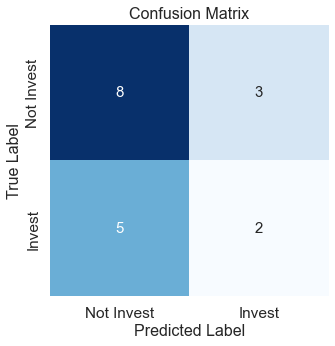

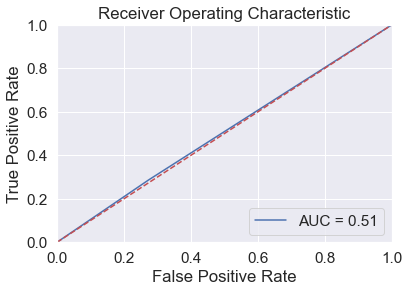

              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.40      0.29      0.33         7

    accuracy                           0.56        18
   macro avg       0.51      0.51      0.50        18
weighted avg       0.53      0.56      0.54        18

F1-score: 0.5
AUC score: 0.5064935064935064
Accuracy score: 0.5555555555555556
Fold: # 2
Best Params: {'C': 1000, 'class_weight': {0: 1, 1: 1.7599999999999998}, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.6032967032967033


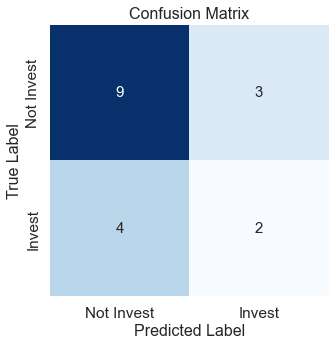

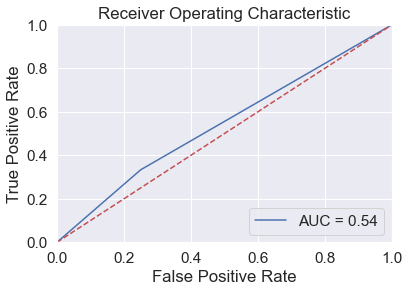

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.40      0.33      0.36         6

    accuracy                           0.61        18
   macro avg       0.55      0.54      0.54        18
weighted avg       0.59      0.61      0.60        18

F1-score: 0.5418181818181818
AUC score: 0.5416666666666666
Accuracy score: 0.6111111111111112
Fold: # 3
Coefficients: [[-0.00224333 -0.00986019 -0.03338963 -0.01573404 -0.00033181 -0.01672298
  -0.00167129 -0.00365488 -0.06855108 -0.06835935 -0.04224022 -0.04230642
  -0.01286646 -0.0156718  -0.08190443 -0.05338978 -0.04474883 -0.066507
  -0.0442929  -0.04119219 -0.0240641  -0.03340004 -0.15200626 -0.13669556
  -0.00375709 -0.01386197 -0.00971281 -0.00830458 -0.00397866 -0.01199733
   0.0197216   0.03071833]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


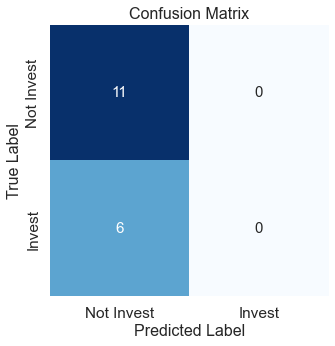

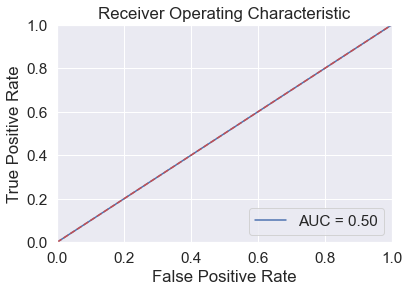

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 4
Coefficients: [[ 0.01356073 -0.00172285 -0.03673737 -0.03984373 -0.00275294 -0.0237015
  -0.00714896 -0.01311418 -0.04865956 -0.04839247 -0.08750468 -0.07563704
  -0.00483027 -0.00162527 -0.06607446 -0.03270262 -0.02810994 -0.03478931
  -0.02670364 -0.01210393 -0.01605438  0.00754737 -0.15729512 -0.15766365
   0.00357383  0.00784296 -0.02619447 -0.01739538  0.00364021  0.06578618
  -0.03728784 -0.05631577]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


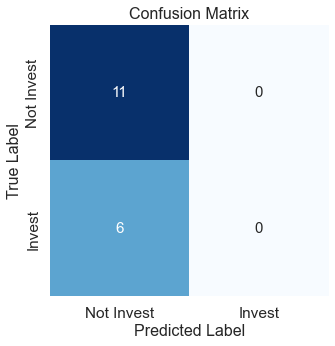

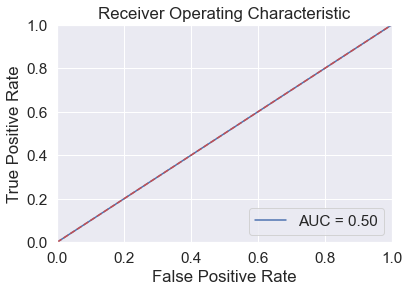

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 5
Coefficients: [[-0.05312232 -0.08863328 -0.05880984 -0.06744458  0.00722956 -0.01243028
  -0.00275358 -0.00460365 -0.05142698 -0.0457975  -0.04526904 -0.0528428
  -0.00545187  0.00238148 -0.04484363 -0.03044035 -0.03064261 -0.04210816
  -0.0500919  -0.02578665 -0.0131777   0.01531806 -0.16596635 -0.15370019
   0.0036411   0.01065518  0.0056158   0.02615774  0.01959061  0.08370598
  -0.00772175 -0.00833134]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


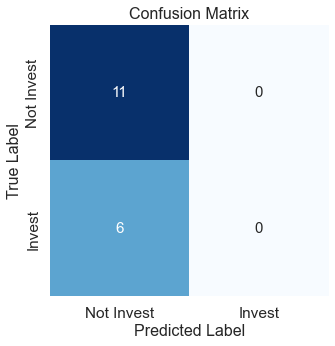

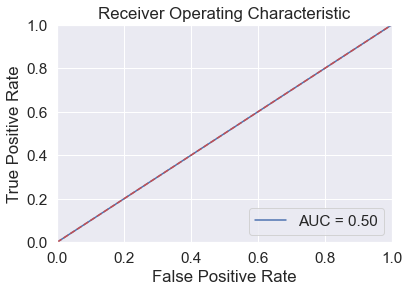

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Variation:  facereader_all
Fold: # 1
Coefficients: [[-2.03227357e+01 -3.05334894e+01 -2.17479458e+01 -4.76400736e+00
   1.01151524e+01 -2.18018634e+01  3.91599802e+01 -1.28559806e+01
  -2.29033942e+01  3.21838118e+01 -2.19634310e+01 -3.61020264e+01
   1.02636237e-01  7.50260734e-01 -1.12339691e+01 -3.26412830e+01
  -4.32505815e+00 -3.56780432e+01 -2.99625358e-03 -4.18699964e-02
   3.34298807e+01 -1.61334952e+01 -5.41435117e+01  3.64282781e+01
  -1.57958923e+01 -2.01180285e+01 -7.60371913e-01 -6.20092036e+00
   5.70268430e+00  1.27696037e+01 -5.93305772e-01 -4.79256825e+00]]
Best Params: 

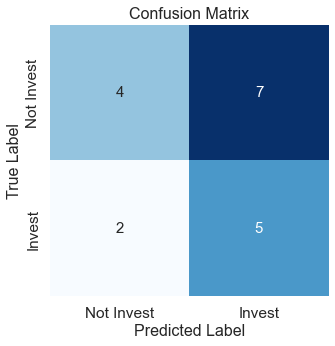

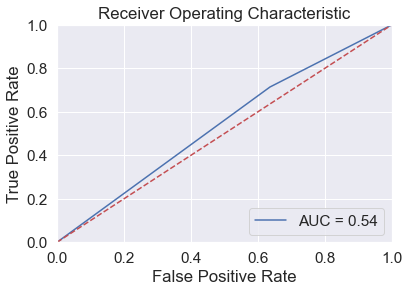

              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.42      0.71      0.53         7

    accuracy                           0.50        18
   macro avg       0.54      0.54      0.50        18
weighted avg       0.57      0.50      0.49        18

F1-score: 0.4984520123839009
AUC score: 0.538961038961039
Accuracy score: 0.5
Fold: # 2
Best Params: {'C': 1000, 'class_weight': {0: 1, 1: 1.7599999999999998}, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.6065934065934067


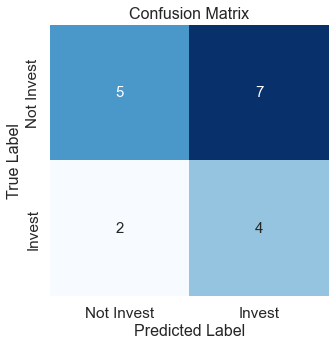

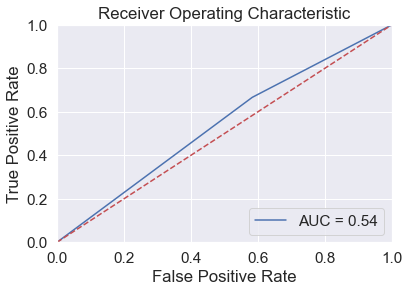

              precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.36      0.67      0.47         6

    accuracy                           0.50        18
   macro avg       0.54      0.54      0.50        18
weighted avg       0.60      0.50      0.51        18

F1-score: 0.4984520123839009
AUC score: 0.5416666666666666
Accuracy score: 0.5
Fold: # 3
Coefficients: [[-1.24648285e-02 -4.10539636e-02 -1.64225789e-02 -3.49223587e-02
  -2.46717899e-02 -3.03524833e-02  1.90692825e-02  1.55144384e-02
  -2.06290720e-02 -3.03138193e-02 -2.81575483e-03 -4.70258314e-03
   1.10299606e-05  1.03377816e-04 -4.26861831e-03 -1.37802895e-02
  -4.37208192e-02 -8.44433521e-02 -6.66858120e-06 -7.45575944e-05
  -2.96560026e-02 -2.51759625e-02 -3.55358410e-02  7.61631721e-03
  -8.34764192e-03 -1.11370196e-02  4.46622536e-04  4.55867600e-04
  -3.37047072e-02 -5.81028892e-02 -1.06247102e-04  5.11748420e-04]]
Best Params: {'C': 0.1, 'class_weight': 

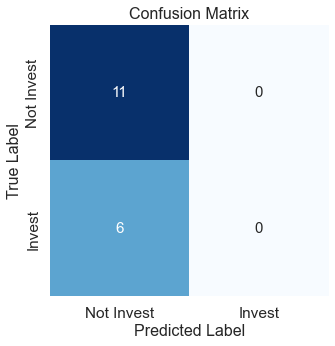

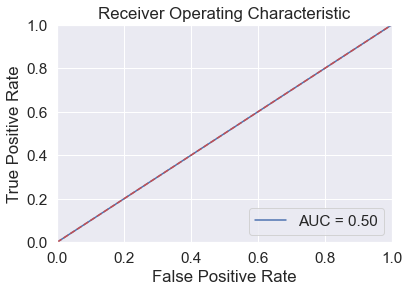

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 4
Coefficients: [[-1.26997849e-02 -3.53809145e-02 -1.27728785e-02 -2.97516887e-02
  -7.21925382e-02 -8.52568494e-02 -1.91997747e-04 -2.33992557e-03
  -2.65659504e-02 -3.97945775e-02 -3.74250068e-03 -8.35994657e-03
   1.10651355e-05  1.04848661e-04 -6.67593513e-04  5.35789024e-04
  -3.07011942e-02 -4.31740901e-02 -1.45306829e-06 -2.36643567e-05
  -1.13152051e-02 -4.42352718e-03 -6.99056669e-02 -3.03570278e-02
  -7.57770646e-03 -8.24476043e-03  2.72821079e-04  5.36220441e-04
  -1.68355136e-04  3.94715523e-02 -9.04005849e-05  3.07676184e-04]]
Best Params: {'C': 0.1, 'class_weight': 

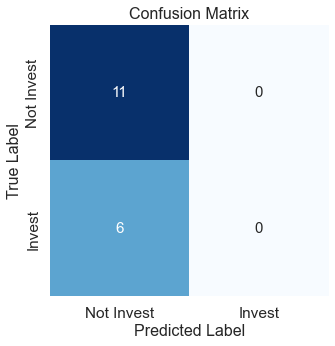

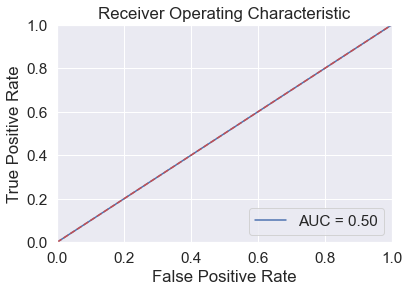

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 5
Coefficients: [[-1.54524366e-02 -4.27543634e-02 -1.71612229e-02 -3.64424621e-02
  -7.85715493e-02 -8.02035329e-02  7.67797081e-03 -3.89248865e-03
  -4.01705266e-04  2.66248598e-03 -4.03237115e-03 -9.05823136e-03
   1.10830167e-05  1.05565121e-04  1.66380266e-03  2.32181029e-03
  -2.06043877e-02 -4.98505086e-02 -7.83854571e-06 -9.47501729e-05
  -4.51111974e-03 -8.84117252e-05 -7.85426895e-02 -7.58681305e-02
  -5.84986144e-03 -1.02135231e-02 -7.42165475e-04 -2.67241785e-03
   2.88146649e-02  7.84167855e-02  1.19017628e-04  2.68647424e-03]]
Best Params: {'C': 0.1, 'class_weight': 

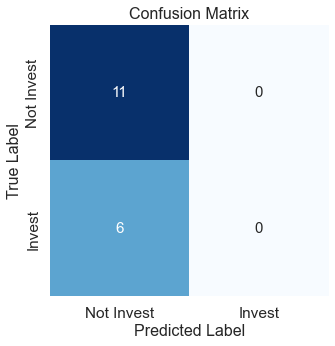

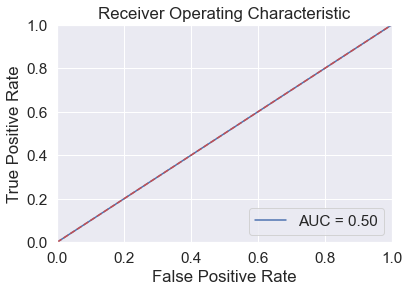

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Variation:  openface_concentration
Fold: # 1
Coefficients: [[-0.00031788 -0.00068774 -0.07358119 -0.08235285  0.01072683  0.03967041
  -0.00857596  0.00340528]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.875}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.5758241758241759


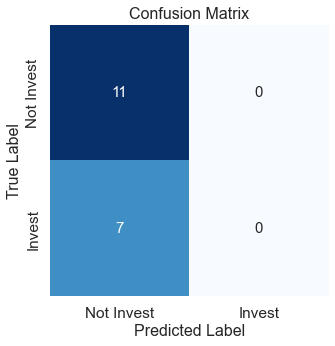

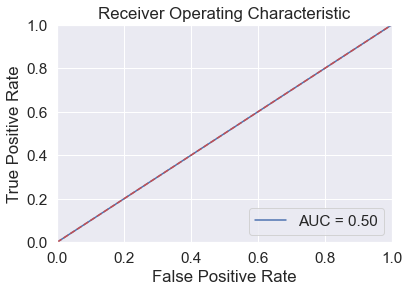

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        11
           1       0.00      0.00      0.00         7

    accuracy                           0.61        18
   macro avg       0.31      0.50      0.38        18
weighted avg       0.37      0.61      0.46        18

F1-score: 0.37931034482758624
AUC score: 0.5
Accuracy score: 0.6111111111111112
Fold: # 2
Best Params: {'C': 100, 'class_weight': {0: 1, 1: 1.7599999999999998}, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.5384615384615385


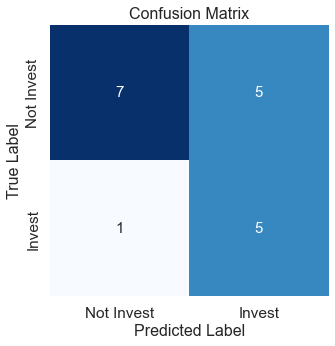

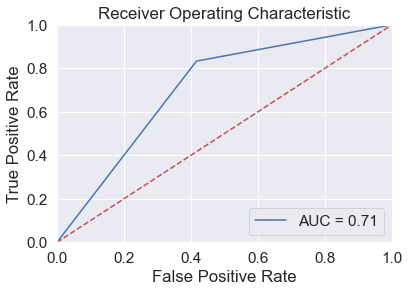

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.50      0.83      0.62         6

    accuracy                           0.67        18
   macro avg       0.69      0.71      0.66        18
weighted avg       0.75      0.67      0.68        18

F1-score: 0.6625000000000001
AUC score: 0.7083333333333334
Accuracy score: 0.6666666666666666
Fold: # 3
Coefficients: [[-0.0007272  -0.00159028 -0.07171996 -0.08065288 -0.00173116 -0.00522019
   0.00858112  0.01336593]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


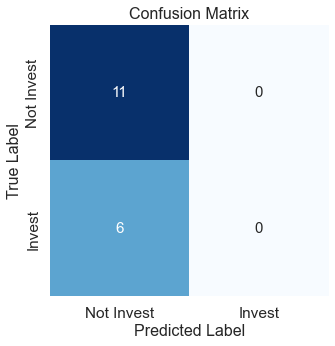

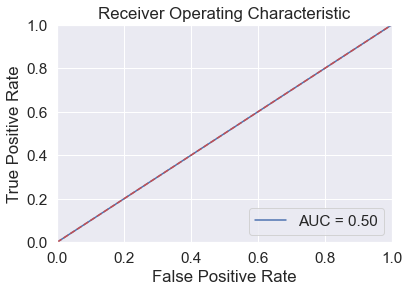

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 4
Coefficients: [[-0.0031106  -0.00570614 -0.08629819 -0.088474    0.0015839   0.02862439
  -0.01622441 -0.0245037 ]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


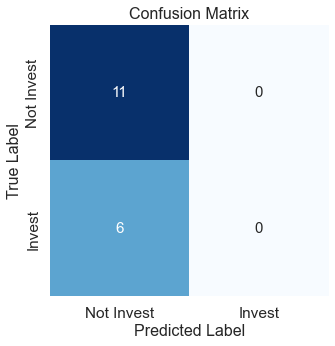

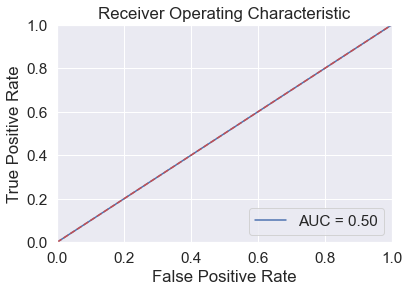

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 5
Coefficients: [[-0.00119812 -0.00200311 -0.06085878 -0.0639814   0.00852412  0.03642152
  -0.00335983 -0.00362507]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


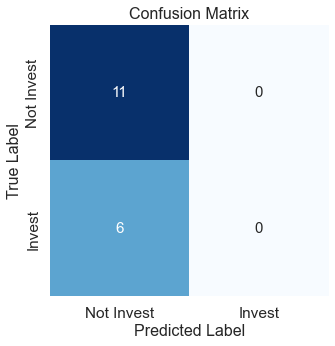

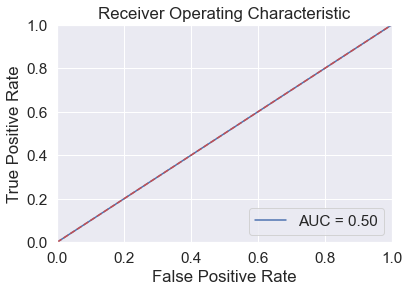

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Variation:  facereader_concentration
Fold: # 1
Best Params: {'C': 1000, 'class_weight': {0: 1, 1: 1.875}, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.5813186813186814


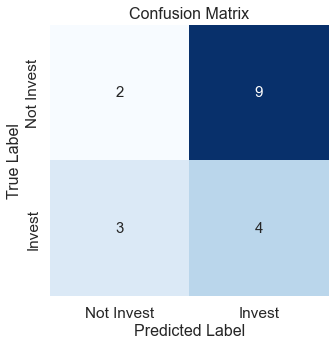

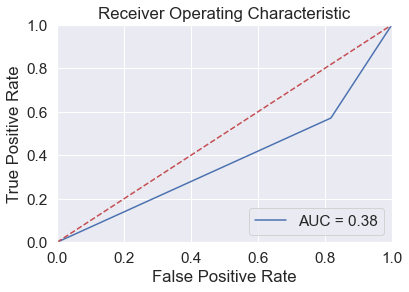

              precision    recall  f1-score   support

           0       0.40      0.18      0.25        11
           1       0.31      0.57      0.40         7

    accuracy                           0.33        18
   macro avg       0.35      0.38      0.33        18
weighted avg       0.36      0.33      0.31        18

F1-score: 0.32500000000000007
AUC score: 0.3766233766233766
Accuracy score: 0.3333333333333333
Fold: # 2
Best Params: {'C': 100, 'class_weight': {0: 1, 1: 1.7599999999999998}, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.567032967032967


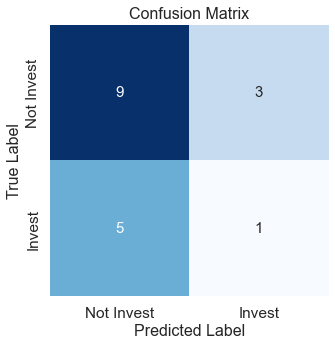

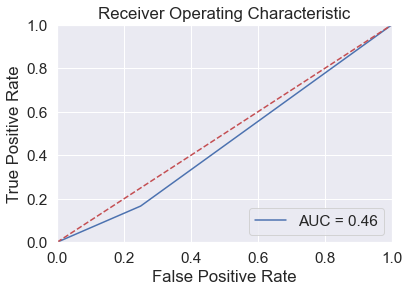

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.25      0.17      0.20         6

    accuracy                           0.56        18
   macro avg       0.45      0.46      0.45        18
weighted avg       0.51      0.56      0.53        18

F1-score: 0.44615384615384623
AUC score: 0.4583333333333333
Accuracy score: 0.5555555555555556
Fold: # 3
Coefficients: [[ 1.56867483e-02  1.27624671e-02 -4.07882874e-02 -7.51944765e-02
  -2.77261224e-02 -4.77965231e-02 -8.74008528e-05  4.20973819e-04]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


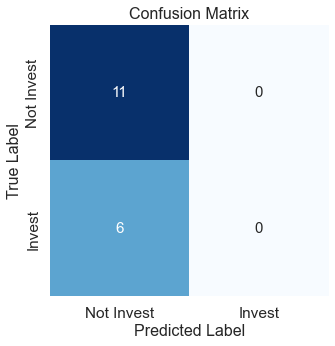

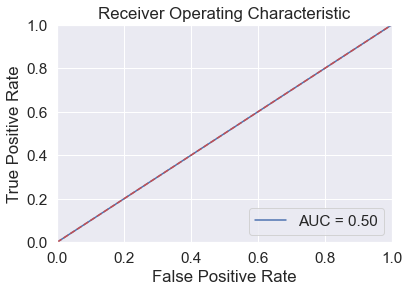

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 4
Coefficients: [[-1.57940937e-04 -1.92486653e-03 -3.28801514e-02 -5.23101680e-02
  -1.38492083e-04  3.24700370e-02 -7.43652115e-05  2.53100182e-04]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


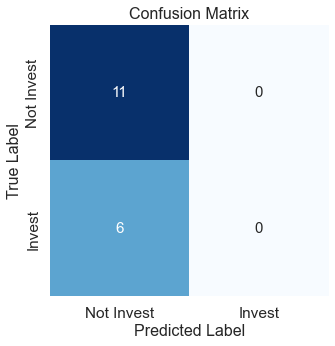

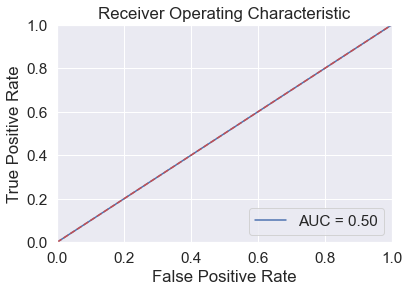

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 5
Coefficients: [[ 6.31604236e-03 -3.20203395e-03 -2.36868160e-02 -5.79059958e-02
   2.37034822e-02  6.45071140e-02  9.79061260e-05  2.20994394e-03]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


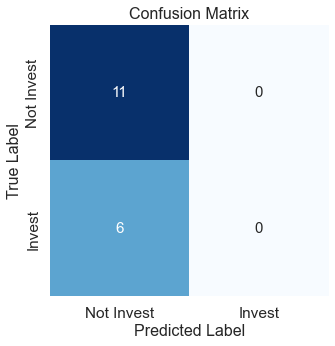

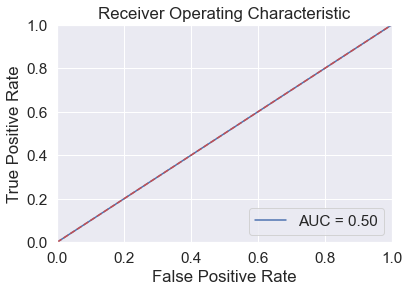

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Variation:  openface_interest
Fold: # 1
Coefficients: [[-0.05615046 -0.0707181  -0.02638513 -0.02278612]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.875}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.5758241758241759


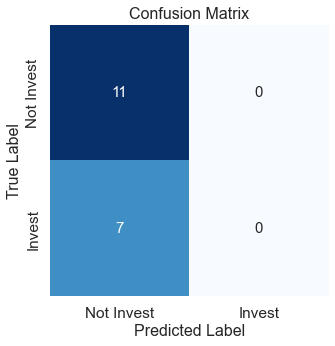

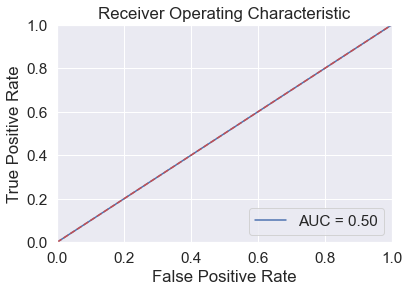

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        11
           1       0.00      0.00      0.00         7

    accuracy                           0.61        18
   macro avg       0.31      0.50      0.38        18
weighted avg       0.37      0.61      0.46        18

F1-score: 0.37931034482758624
AUC score: 0.5
Accuracy score: 0.6111111111111112
Fold: # 2
Best Params: {'C': 1000, 'class_weight': {0: 1, 1: 1.7599999999999998}, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.4769230769230769


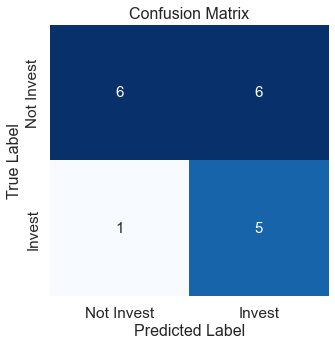

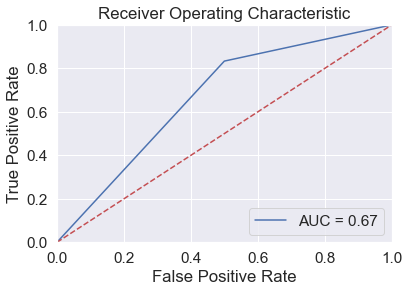

              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.45      0.83      0.59         6

    accuracy                           0.61        18
   macro avg       0.66      0.67      0.61        18
weighted avg       0.72      0.61      0.62        18

F1-score: 0.609907120743034
AUC score: 0.6666666666666667
Accuracy score: 0.6111111111111112
Fold: # 3
Coefficients: [[-0.0786545  -0.09202372 -0.01518218 -0.01520597]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


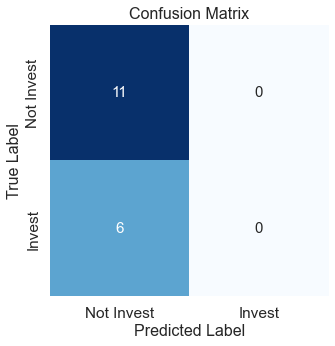

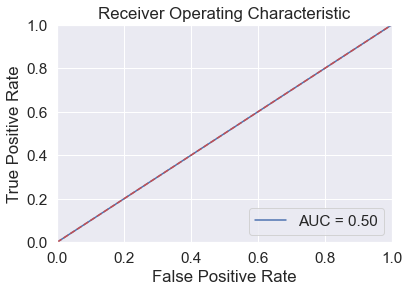

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 4
Coefficients: [[-0.05103434 -0.05617239 -0.03145134 -0.02718582]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


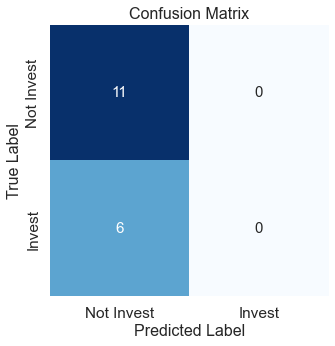

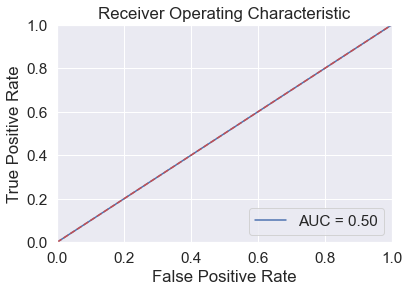

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 5


/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Coefficients: [[-0.05459729 -0.05899699 -0.01627081 -0.01899301]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


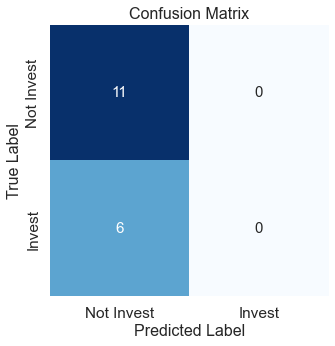

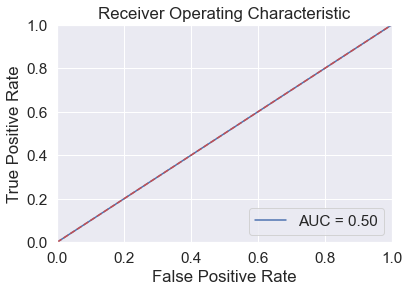

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Variation:  facereader_interest
Fold: # 1
Coefficients: [[-0.0336684  -0.06083304 -0.00124313 -0.00282277]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.875}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.5758241758241759


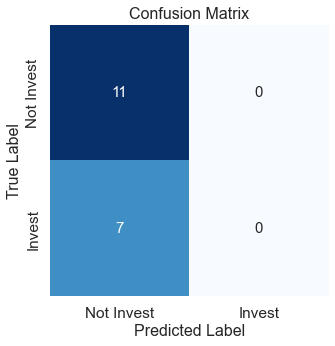

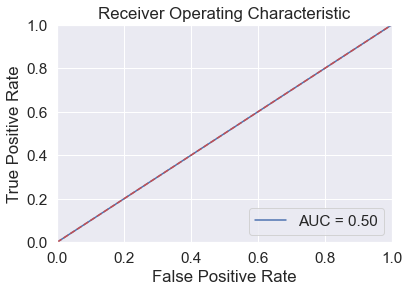

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        11
           1       0.00      0.00      0.00         7

    accuracy                           0.61        18
   macro avg       0.31      0.50      0.38        18
weighted avg       0.37      0.61      0.46        18

F1-score: 0.37931034482758624
AUC score: 0.5
Accuracy score: 0.6111111111111112
Fold: # 2
Best Params: {'C': 10, 'class_weight': {0: 1, 1: 1.7599999999999998}, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.4230769230769231


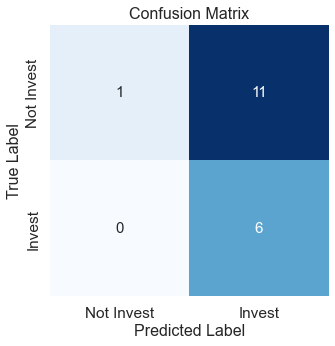

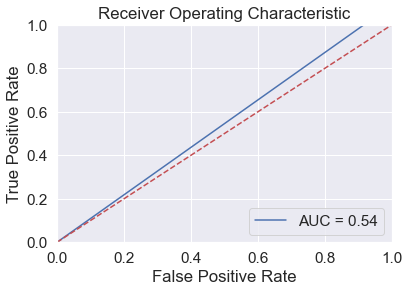

              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.35      1.00      0.52         6

    accuracy                           0.39        18
   macro avg       0.68      0.54      0.34        18
weighted avg       0.78      0.39      0.28        18

F1-score: 0.3377926421404682
AUC score: 0.5416666666666667
Accuracy score: 0.3888888888888889
Fold: # 3
Coefficients: [[-0.03764003 -0.06834119 -0.00091318 -0.00152509]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


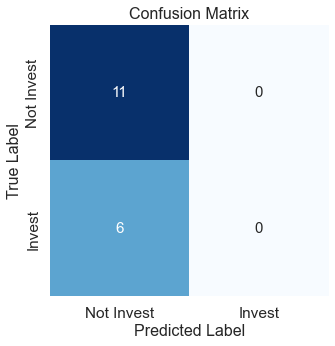

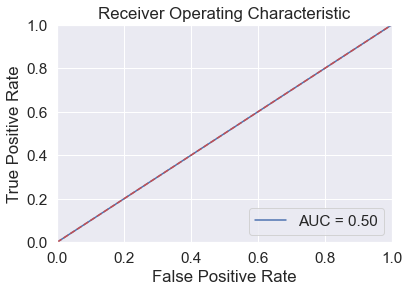

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 4
Coefficients: [[-0.03270679 -0.04672445 -0.00121373 -0.00271121]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


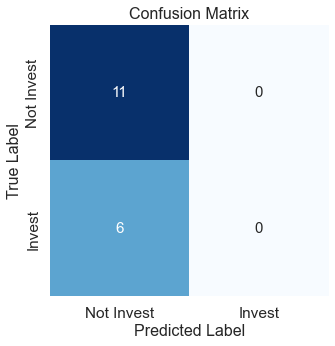

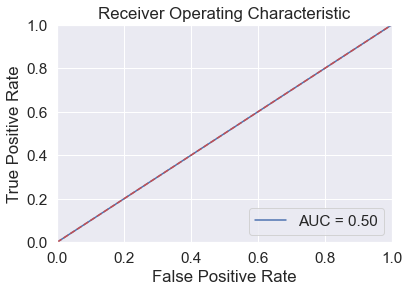

/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118
Fold: # 5
Coefficients: [[-0.01182365 -0.02546968 -0.00130774 -0.00293767]]
Best Params: {'C': 0.1, 'class_weight': {0: 1, 1: 1.7999999999999998}, 'gamma': 1, 'kernel': 'linear'}
Best Score: 0.6428571428571429


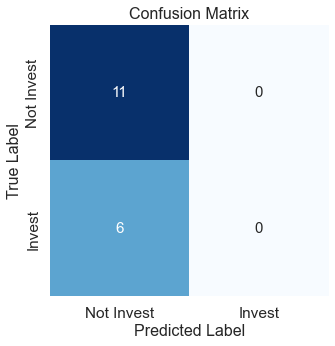

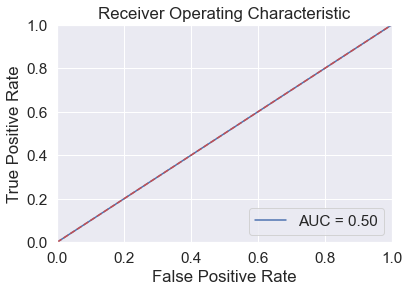

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17

F1-score: 0.3928571428571429
AUC score: 0.5
Accuracy score: 0.6470588235294118


/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aryaprabawa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
for key in svm_features:
    print('Variation: ', key)
    X = svm_features[key]
    fold = 1
    f1_scores = []
    roc_auc_scores = []
    accuracy_scores = []
    for train, test in kf.split(X, y):
        print('Fold: #', fold)

        y_train = y[train]
        bias = y_train[y_train == 1].shape[0]/y_train[y_train == 0].shape[0]

        parameters = {
            'kernel':['linear', 'rbf'],
            'C':[0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'class_weight': [{0: 1, 1: 1/bias}]
        }

        svc = svm.SVC()
        clf = GridSearchCV(
            estimator=svc, 
            param_grid=parameters,
            n_jobs=-1,
            scoring=['f1_macro', 'roc_auc', 'accuracy'],
            refit='accuracy' 
        )
        clf.fit(X[train], y[train])

        if clf.best_params_['kernel'] == 'linear':
            print('Coefficients:', clf.best_estimator_.coef_)
        print('Best Params:', clf.best_params_)
        print('Best Score:', clf.best_score_)

        y_pred = clf.predict(X[test])

        show_confusion_matrix(y[test], y_pred)
        show_roc_plot(y[test], y_pred)

        print(classification_report(y[test], y_pred))
        f1 = f1_score(y[test], y_pred, average='macro')
        print('F1-score:', f1)
        f1_scores.append(f1)
        roc_auc = roc_auc_score(y[test], y_pred)
        print('AUC score:', roc_auc)
        roc_auc_scores.append(roc_auc)
        accuracy = accuracy_score(y[test], y_pred)
        print('Accuracy score:', accuracy)
        accuracy_scores.append(accuracy)

        fold = fold + 1

**LSTM**

In [45]:
def make_model(recurrent_units,
               batch_size,
               epochs,
               dropout_rate,
               optimizer,
               learning_rate,
               n_timesteps,
               n_features,
               n_outputs):
    
    model = Sequential()
    
    model.add(LSTM(recurrent_units, input_shape=(n_timesteps,n_features), recurrent_dropout=dropout_rate))
    model.add(Dense(n_outputs, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer(lr=learning_rate), metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
    
    return model

Variation:  openface_all_frame
Fold: # 1


2022-01-21 11:43:08.390389: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-21 11:43:08.390786: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-21 11:43:08.390389: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
2022-01-21 11:44:50.680667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 11:44:50.680667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 11:44:50.686336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  w

2022-01-21 12:01:07.348284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-01-21 12:01:07.586591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Best Params: {'clf__verbose': 0, 'clf__recurrent_units': 25, 'clf__optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'clf__n_timesteps': 70, 'clf__n_outputs': 1, 'clf__n_features': 16, 'clf__learning_rate': 0.1, 'clf__epochs': 200, 'clf__dropout_rate': 0.05, 'clf__class_weight': {0: 1, 1: 1.875}, 'clf__batch_size': 10}


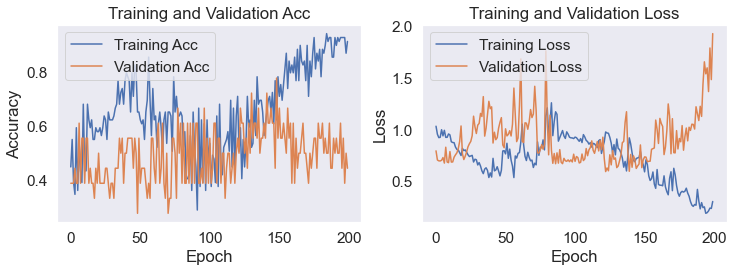

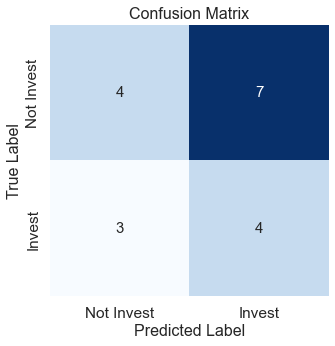

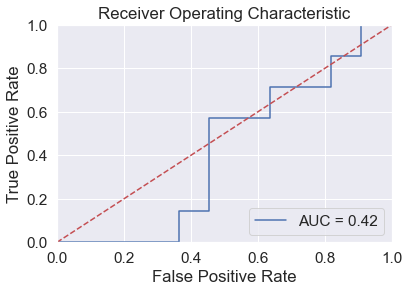

              precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.36      0.57      0.44         7

    accuracy                           0.44        18
   macro avg       0.47      0.47      0.44        18
weighted avg       0.49      0.44      0.44        18

F1-score: 0.4444444444444444
AUC score: 0.46753246753246747
Accuracy score: 0.4444444444444444
Fold: # 2


/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(mode

/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(mode

/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/aryaprabawa/.local/l

/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best Params: {'clf__verbose': 0, 'clf__recurrent_units': 25, 'clf__optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>, 'clf__n_timesteps': 70, 'clf__n_outputs': 1, 'clf__n_features': 16, 'clf__learning_rate': 0.001, 'clf__epochs': 100, 'clf__dropout_rate': 0.05, 'clf__class_weight': {0: 1, 1: 1.7599999999999998}, 'clf__batch_size': 10}


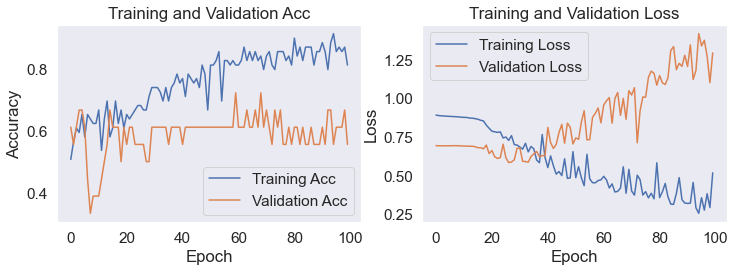

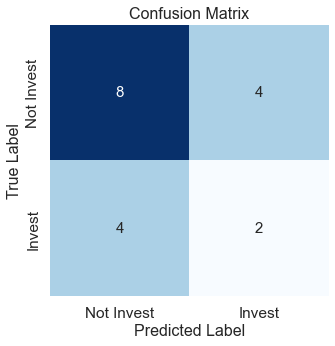

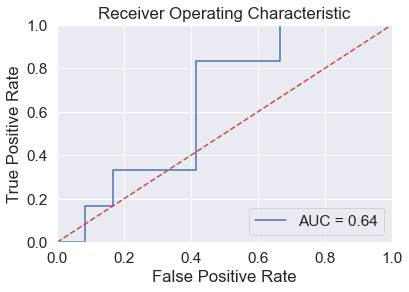

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.33      0.33      0.33         6

    accuracy                           0.56        18
   macro avg       0.50      0.50      0.50        18
weighted avg       0.56      0.56      0.56        18

F1-score: 0.5
AUC score: 0.5
Accuracy score: 0.5555555555555556
Fold: # 3


/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/aryaprabawa/.local/l

/Users/aryaprabawa/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Best Params: {'clf__verbose': 0, 'clf__recurrent_units': 125, 'clf__optimizer': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>, 'clf__n_timesteps': 70, 'clf__n_outputs': 1, 'clf__n_features': 16, 'clf__learning_rate': 0.001, 'clf__epochs': 100, 'clf__dropout_rate': 0.5, 'clf__class_weight': {0: 1, 1: 1.7999999999999998}, 'clf__batch_size': 15}


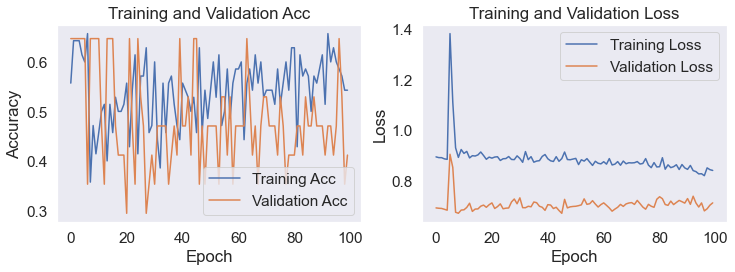

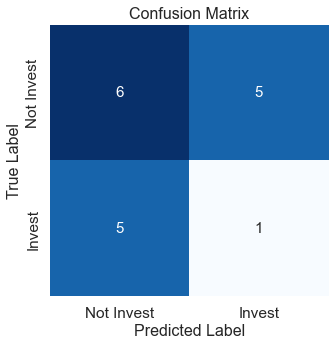

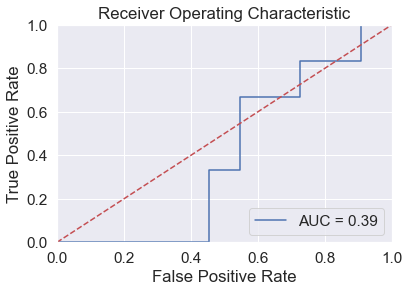

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.17      0.17      0.17         6

    accuracy                           0.41        17
   macro avg       0.36      0.36      0.36        17
weighted avg       0.41      0.41      0.41        17

F1-score: 0.356060606060606
AUC score: 0.3560606060606061
Accuracy score: 0.4117647058823529
Fold: # 4


KeyboardInterrupt: 

In [48]:
for key in lstm_features:
    print('Variation: ', key)
    X = lstm_features[key]
    fold = 1
    verbose = 0
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], 1
    f1_scores = []
    roc_auc_scores = []
    accuracy_scores = []
    for train, test in kf.split(X, y):
        print('Fold: #', fold)

        y_train = y[train]
        bias = y_train[y_train == 1].shape[0]/y_train[y_train == 0].shape[0]

        keras_pipeline = Pipeline([("clf", KerasClassifier(build_fn=make_model))
        ])

        param_grid = {
            'clf__recurrent_units': [25, 50, 75, 100, 125],
            'clf__batch_size': [1, 5, 10, 15, 35],
            'clf__epochs': [10, 20, 50, 100, 200],
            'clf__dropout_rate': [0.0, 0.05, 0.1, 0.25, 0.5],
            'clf__optimizer': [optimizers.Adam, optimizers.Nadam, optimizers.RMSprop],
            'clf__learning_rate': [0.1, 0.01, 0.001, 0.0001, 0.00001],
            'clf__class_weight': [{0: 1, 1: 1/bias}],
            'clf__n_timesteps': [n_timesteps],
            'clf__n_features': [n_features],
            'clf__n_outputs': [n_outputs],
            'clf__verbose': [verbose],
        }

        rs_keras = RandomizedSearchCV(keras_pipeline,
                                      param_distributions=param_grid,
                                      refit='accuracy',
                                      n_iter=10,
                                      n_jobs=-1,
                                      scoring=['f1_macro', 'roc_auc', 'accuracy'])

        rs_keras.fit(X[train], y[train])

        print('Best Params:', rs_keras.best_params_)

        model = make_model(
            recurrent_units=rs_keras.best_params_['clf__recurrent_units'],
            batch_size=rs_keras.best_params_['clf__batch_size'],
            epochs=rs_keras.best_params_['clf__epochs'],
            dropout_rate=rs_keras.best_params_['clf__dropout_rate'],
            optimizer=rs_keras.best_params_['clf__optimizer'],
            learning_rate=rs_keras.best_params_['clf__learning_rate'],
            n_timesteps=n_timesteps,
            n_features=n_features,
            n_outputs=n_outputs
        )

        history = model.fit(X[train], y[train],
                  batch_size=rs_keras.best_params_['clf__batch_size'],
                  epochs=rs_keras.best_params_['clf__epochs'],
                  verbose=verbose,
                  validation_data=(X[test], y[test]),
                  class_weight={0: 1, 1: 1/bias}
        )

        show_training_plot(history)

        y_pred = model.predict(X[test])

        show_confusion_matrix(y[test], y_pred)
        show_roc_plot(y[test], y_pred)

        y_pred_classes = (y_pred > 0.5).astype("int32")

        print(classification_report(y[test], y_pred_classes))
        f1 = f1_score(y[test], y_pred_classes, average='macro')
        print('F1-score:', f1)
        f1_scores.append(f1)
        roc_auc = roc_auc_score(y[test], y_pred_classes)
        print('AUC score:', roc_auc)
        roc_auc_scores.append(roc_auc)
        accuracy = accuracy_score(y[test], y_pred_classes)
        print('Accuracy score:', accuracy)
        accuracy_scores.append(accuracy)

        fold = fold + 1